In [1]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from PIL import Image
import splitfolders
import visualkeras

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.6.0


In [2]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [3]:
%cd /Users/irfanmasudi/ANNDL/Challenge/

/Users/irfanmasudi/ANNDL/Challenge


In [4]:
# Dataset folders 
dataset_dir = 'datasets'
training_dir = os.path.join(dataset_dir, 'train')
validation_dir = os.path.join(dataset_dir, 'val')
#test_dir = os.path.join(dataset_dir, 'test')

In [5]:
# Plot example images from dataset
labels = ['Apple',       # 0
          'Blueberry',   # 1
          'Cherry',      # 2
          'Corn',        # 3
          'Grape',       # 4
          'Orange',      # 5
          'Peach',       # 6
          'Pepper',      # 7
          'Potato',      # 8
          'Raspberry',   # 9
          'Soybean',     # 10
          'Squash',      # 11
          'Strawberry',  # 12
          'Tomato']      # 13

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

valid_data_gen = ImageDataGenerator(rotation_range=40,
                                        height_shift_range=60,
                                        width_shift_range=60,
                                        zoom_range=0.5,
                                        horizontal_flip=True,
                                        vertical_flip=True, 
                                        fill_mode='reflect',
                                        rescale=1/255.)

# Create an instance of ImageDataGenerator with Data Augmentation
aug_train_data_gen = ImageDataGenerator(rotation_range=30,
                                        height_shift_range=50,
                                        width_shift_range=50,
                                        zoom_range=0.3,
                                        horizontal_flip=True,
                                        vertical_flip=True, 
                                        fill_mode='reflect',
                                        rescale=1/255.) # rescale value is multiplied to the image

# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
train_gen = aug_train_data_gen.flow_from_directory(directory=training_dir,
                                                       target_size=(256,256),
                                                       color_mode='grayscale',
                                                       classes=None, # can be set to labels
                                                       class_mode='categorical',
                                                       batch_size=64,
                                                       shuffle=True,
                                                       seed=seed)

valid_gen = valid_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size=(256,256),
                                               color_mode='grayscale',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=64,
                                               shuffle=False,
                                               seed=seed)

Found 15062 images belonging to 14 classes.
Found 2666 images belonging to 14 classes.


In [7]:
def get_next_batch(generator):
    batch = next(generator)

    image = batch[0]
    target = batch[1]

    print("(Input) image shape:", image.shape)
    print("Target shape:",target.shape)

    # Visualize only the first sample
    image = image[0]
    target = target[0]
    target_idx = np.argmax(target)
    print()
    print("Categorical label:", target)
    print("Label:", target_idx)
    print("Class name:", labels[target_idx])
    
    fig = plt.figure(figsize=(6, 4))
    plt.imshow(np.uint8(image))
    plt.show()
    
    return batch

(Input) image shape: (64, 256, 256, 1)
Target shape: (64, 14)

Categorical label: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Label: 13
Class name: Tomato


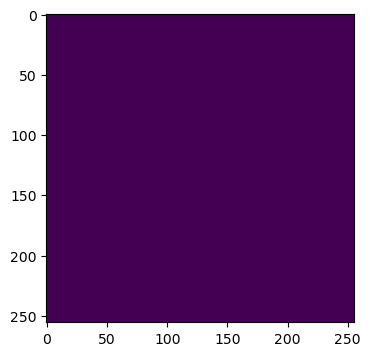

In [8]:
# Get a sample from dataset and show info
_ = get_next_batch(train_gen)

In [9]:
from sklearn.utils import compute_class_weight

class_weights = compute_class_weight(class_weight = "balanced",
                                     classes = np.unique(train_gen.classes),
                                     y = train_gen.classes                                                    
                                    )
class_weights = dict(zip(np.unique(train_gen.classes), class_weights))
class_weights

{0: 1.282308871105057,
 1: 2.716810966810967,
 2: 2.1734487734487735,
 3: 1.049616724738676,
 4: 0.8683269918136747,
 5: 0.7244829244829245,
 6: 1.2962134251290878,
 7: 1.6551648351648351,
 8: 1.769501879699248,
 9: 4.802933673469388,
 10: 0.7835813130787639,
 11: 2.2091522440598417,
 12: 1.8808691308691308,
 13: 0.22233046969562778}

In [10]:
print("Assigned labels")
print(train_gen.class_indices)
print()
print("Target classes")
print(train_gen.classes)

Assigned labels
{'Apple': 0, 'Blueberry': 1, 'Cherry': 2, 'Corn': 3, 'Grape': 4, 'Orange': 5, 'Peach': 6, 'Pepper': 7, 'Potato': 8, 'Raspberry': 9, 'Soybean': 10, 'Squash': 11, 'Strawberry': 12, 'Tomato': 13}

Target classes
[ 0  0  0 ... 13 13 13]


In [11]:
input_shape = (256, 256, 1)
epochs = 200

In [12]:
METRICS = [
      tfk.metrics.TruePositives(name='tp'),
      tfk.metrics.FalsePositives(name='fp'),
      tfk.metrics.TrueNegatives(name='tn'),
      tfk.metrics.FalseNegatives(name='fn'), 
      tfk.metrics.BinaryAccuracy(name='accuracy'),
      tfk.metrics.Precision(name='precision'),
      tfk.metrics.Recall(name='recall'),
      tfk.metrics.AUC(name='auc'),
]

In [13]:
# Model used for the exercise:
# (Conv + ReLU + MaxPool) x 5 + FC x 2
def build_model(input_shape):

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    conv1 = tfkl.Conv2D(
        filters=16,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(input_layer)
    
    batchNorm1 = tfkl.BatchNormalization()(conv1)
    
    relu1 = tfk.activations.relu(batchNorm1)
    
    dropout1 = tfkl.Dropout(0.3)(relu1)
    
    pool1 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(dropout1)

    conv2 = tfkl.Conv2D(
        filters=32,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool1)

    batchNorm2 = tfkl.BatchNormalization()(conv2)
    
    relu2 = tfk.activations.relu(batchNorm2)
    
    dropout2 = tfkl.Dropout(0.3)(relu2)
    
    pool2 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(dropout2)
    
    
    conv3 = tfkl.Conv2D(
        filters=64,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool2)

    batchNorm3 = tfkl.BatchNormalization()(conv3)
    
    relu3 = tfk.activations.relu(batchNorm3)
    
    dropout3 = tfkl.Dropout(0.3)(relu3)
    
    pool3 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(dropout3)

    conv4 = tfkl.Conv2D(
        filters=128,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool3)
    
    batchNorm4 = tfkl.BatchNormalization()(conv4)
    
    relu4 = tfk.activations.relu(batchNorm4)
    
    dropout4 = tfkl.Dropout(0.3)(relu4)
    
    pool4 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(dropout4)

    conv5 = tfkl.Conv2D(
        filters=256,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool4)
    
    batchNorm5 = tfkl.BatchNormalization()(conv5)
    
    relu5 = tfk.activations.relu(batchNorm5)
    
    glob_pooling = tfkl.GlobalAveragePooling2D(name='GlobalAvglPooling')(relu5)
    glob_pooling = tfkl.Dropout(0.3, seed=seed, name='GAPDropout')(glob_pooling)
    
    dense1 = tfkl.Dense(
        units=256,  
        activation='relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed),
        name='dense1')(glob_pooling)
    dense1 = tfkl.Dropout(0.3, seed=seed, name='DenseDropout')(dense1)

    classifier_layer = tfkl.Dense(
        units=256,  
        activation='relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed),
        name='Classifier')(dense1)
    classifier_layer = tfkl.Dropout(0.3, seed=seed, name='ClassifierDropout')(classifier_layer)

    output_layer = tfkl.Dense(
        units=14, 
        activation='softmax', 
        kernel_initializer = tfk.initializers.GlorotUniform(seed),
        name='Output')(classifier_layer)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model_GAP_BN')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=METRICS)

    # Return the model
    return model

In [14]:
# Utility function to create folders and callbacks for training
from datetime import datetime

def create_folders_and_callbacks(model_name):
    exps_dir = os.path.join('logs/Grayscale')
    if not os.path.exists(exps_dir):
        os.makedirs(exps_dir)

    now = datetime.now().strftime('%b%d_%H-%M-%S')

    exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
    if not os.path.exists(exp_dir):
        os.makedirs(exp_dir)
      
    callbacks = []

  # Model checkpoint
  # ----------------
    ckpt_dir = os.path.join(exp_dir, 'ckpts')
    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir)

    ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), 
                                                     save_weights_only=False, # True to save only weights
                                                     save_best_only=False) # True to save only the best epoch 
    callbacks.append(ckpt_callback)

  # Visualize Learning on Tensorboard
  # ---------------------------------
    tb_dir = os.path.join(exp_dir, 'tb_logs')
    if not os.path.exists(tb_dir):
        os.makedirs(tb_dir)
      
  # By default shows losses and metrics for both training and validation
    tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir, 
                                               profile_batch=0,
                                               histogram_freq=1)  # if > 0 (epochs) shows weights histograms
    callbacks.append(tb_callback)

  # Early Stopping
  # --------------
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_auc', patience=10, 
                                                   restore_best_weights=True, 
                                                   verbose=1,
                                                   mode='max',)
    callbacks.append(es_callback)

    return callbacks

Model: "model_GAP_BN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 256, 256, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 16)      160       
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 256, 16)      64        
_________________________________________________________________
tf.nn.relu (TFOpLambda)      (None, 256, 256, 16)      0         
_________________________________________________________________
dropout (Dropout)            (None, 256, 256, 16)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)     

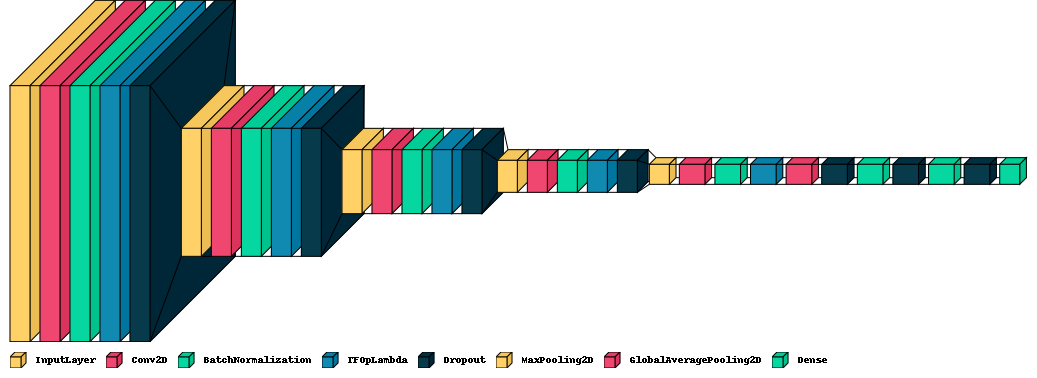

In [15]:
model = build_model(input_shape)
model.summary()
visualkeras.layered_view(model, legend=True, spacing=10, scale_xy=1)

In [16]:
tf.get_logger().setLevel('WARNING') #  if you want to suppress only INFOs
tf.get_logger().setLevel('ERROR') #  if you want to suppress both WARNINGs and INFOs

# Create folders and callbacks and fit
train_callbacks = create_folders_and_callbacks(model_name='BatchNormGray')

# Train the model
history = model.fit(
    x = train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    callbacks = train_callbacks,
    class_weight = class_weights,
).history

Epoch 1/200
236/236 [==============================] - 130s 544ms/step - loss: 1.9068 - tp: 1643.0000 - fp: 1216.0000 - tn: 194590.0000 - fn: 13419.0000 - accuracy: 0.9306 - precision: 0.5747 - recall: 0.1091 - auc: 0.8255 - val_loss: 4.3395 - val_tp: 3.0000 - val_fp: 24.0000 - val_tn: 34634.0000 - val_fn: 2663.0000 - val_accuracy: 0.9280 - val_precision: 0.1111 - val_recall: 0.0011 - val_auc: 0.5478


Epoch 2/200
236/236 [==============================] - 132s 557ms/step - loss: 1.4408 - tp: 4199.0000 - fp: 2156.0000 - tn: 193650.0000 - fn: 10863.0000 - accuracy: 0.9383 - precision: 0.6607 - recall: 0.2788 - auc: 0.9014 - val_loss: 4.8302 - val_tp: 155.0000 - val_fp: 1196.0000 - val_tn: 33462.0000 - val_fn: 2511.0000 - val_accuracy: 0.9007 - val_precision: 0.1147 - val_recall: 0.0581 - val_auc: 0.5608


Epoch 3/200
236/236 [==============================] - 138s 586ms/step - loss: 1.1541 - tp: 6109.0000 - fp: 2507.0000 - tn: 193299.0000 - fn: 8953.0000 - accuracy: 0.9457 - precision: 0.7090 - recall: 0.4056 - auc: 0.9355 - val_loss: 3.0704 - val_tp: 672.0000 - val_fp: 687.0000 - val_tn: 33971.0000 - val_fn: 1994.0000 - val_accuracy: 0.9282 - val_precision: 0.4945 - val_recall: 0.2521 - val_auc: 0.7232


Epoch 4/200
236/236 [==============================] - 144s 608ms/step - loss: 0.9313 - tp: 8023.0000 - fp: 2614.0000 - tn: 193192.0000 - fn: 7039.0000 - accuracy: 0.9542 - precision: 0.7543 - recall: 0.5327 - auc: 0.9561 - val_loss: 2.8713 - val_tp: 500.0000 - val_fp: 1087.0000 - val_tn: 33571.0000 - val_fn: 2166.0000 - val_accuracy: 0.9128 - val_precision: 0.3151 - val_recall: 0.1875 - val_auc: 0.7441


Epoch 5/200
236/236 [==============================] - 131s 556ms/step - loss: 0.8130 - tp: 8932.0000 - fp: 2551.0000 - tn: 193255.0000 - fn: 6130.0000 - accuracy: 0.9588 - precision: 0.7778 - recall: 0.5930 - auc: 0.9642 - val_loss: 4.4622 - val_tp: 444.0000 - val_fp: 1985.0000 - val_tn: 32673.0000 - val_fn: 2222.0000 - val_accuracy: 0.8873 - val_precision: 0.1828 - val_recall: 0.1665 - val_auc: 0.6540


Epoch 6/200
236/236 [==============================] - 136s 575ms/step - loss: 0.7166 - tp: 9650.0000 - fp: 2361.0000 - tn: 193445.0000 - fn: 5412.0000 - accuracy: 0.9631 - precision: 0.8034 - recall: 0.6407 - auc: 0.9704 - val_loss: 2.9307 - val_tp: 628.0000 - val_fp: 1557.0000 - val_tn: 33101.0000 - val_fn: 2038.0000 - val_accuracy: 0.9037 - val_precision: 0.2874 - val_recall: 0.2356 - val_auc: 0.7778


Epoch 7/200
236/236 [==============================] - 129s 545ms/step - loss: 0.6600 - tp: 10153.0000 - fp: 2317.0000 - tn: 193489.0000 - fn: 4909.0000 - accuracy: 0.9657 - precision: 0.8142 - recall: 0.6741 - auc: 0.9739 - val_loss: 3.8270 - val_tp: 434.0000 - val_fp: 1784.0000 - val_tn: 32874.0000 - val_fn: 2232.0000 - val_accuracy: 0.8924 - val_precision: 0.1957 - val_recall: 0.1628 - val_auc: 0.7085


Epoch 8/200
236/236 [==============================] - 136s 574ms/step - loss: 0.5716 - tp: 10817.0000 - fp: 2139.0000 - tn: 193667.0000 - fn: 4245.0000 - accuracy: 0.9697 - precision: 0.8349 - recall: 0.7182 - auc: 0.9791 - val_loss: 1.9662 - val_tp: 891.0000 - val_fp: 900.0000 - val_tn: 33758.0000 - val_fn: 1775.0000 - val_accuracy: 0.9283 - val_precision: 0.4975 - val_recall: 0.3342 - val_auc: 0.8573


Epoch 9/200
236/236 [==============================] - 128s 540ms/step - loss: 0.5419 - tp: 11064.0000 - fp: 2053.0000 - tn: 193753.0000 - fn: 3998.0000 - accuracy: 0.9713 - precision: 0.8435 - recall: 0.7346 - auc: 0.9810 - val_loss: 3.8579 - val_tp: 510.0000 - val_fp: 1834.0000 - val_tn: 32824.0000 - val_fn: 2156.0000 - val_accuracy: 0.8931 - val_precision: 0.2176 - val_recall: 0.1913 - val_auc: 0.7292


Epoch 10/200
236/236 [==============================] - 126s 532ms/step - loss: 0.5028 - tp: 11285.0000 - fp: 1989.0000 - tn: 193817.0000 - fn: 3777.0000 - accuracy: 0.9727 - precision: 0.8502 - recall: 0.7492 - auc: 0.9827 - val_loss: 4.1782 - val_tp: 531.0000 - val_fp: 1900.0000 - val_tn: 32758.0000 - val_fn: 2135.0000 - val_accuracy: 0.8919 - val_precision: 0.2184 - val_recall: 0.1992 - val_auc: 0.7237


Epoch 11/200
236/236 [==============================] - 129s 544ms/step - loss: 0.4764 - tp: 11540.0000 - fp: 1945.0000 - tn: 193861.0000 - fn: 3522.0000 - accuracy: 0.9741 - precision: 0.8558 - recall: 0.7662 - auc: 0.9843 - val_loss: 3.6150 - val_tp: 589.0000 - val_fp: 1694.0000 - val_tn: 32964.0000 - val_fn: 2077.0000 - val_accuracy: 0.8990 - val_precision: 0.2580 - val_recall: 0.2209 - val_auc: 0.7335


Epoch 12/200
236/236 [==============================] - 125s 529ms/step - loss: 0.4410 - tp: 11773.0000 - fp: 1824.0000 - tn: 193982.0000 - fn: 3289.0000 - accuracy: 0.9758 - precision: 0.8659 - recall: 0.7816 - auc: 0.9859 - val_loss: 5.6195 - val_tp: 394.0000 - val_fp: 2149.0000 - val_tn: 32509.0000 - val_fn: 2272.0000 - val_accuracy: 0.8816 - val_precision: 0.1549 - val_recall: 0.1478 - val_auc: 0.6359


Epoch 13/200
236/236 [==============================] - 140s 594ms/step - loss: 0.4186 - tp: 11991.0000 - fp: 1734.0000 - tn: 194072.0000 - fn: 3071.0000 - accuracy: 0.9772 - precision: 0.8737 - recall: 0.7961 - auc: 0.9872 - val_loss: 5.5941 - val_tp: 345.0000 - val_fp: 2181.0000 - val_tn: 32477.0000 - val_fn: 2321.0000 - val_accuracy: 0.8794 - val_precision: 0.1366 - val_recall: 0.1294 - val_auc: 0.6435


Epoch 14/200
236/236 [==============================] - 129s 545ms/step - loss: 0.3826 - tp: 12132.0000 - fp: 1656.0000 - tn: 194150.0000 - fn: 2930.0000 - accuracy: 0.9783 - precision: 0.8799 - recall: 0.8055 - auc: 0.9878 - val_loss: 4.3193 - val_tp: 476.0000 - val_fp: 1990.0000 - val_tn: 32668.0000 - val_fn: 2190.0000 - val_accuracy: 0.8880 - val_precision: 0.1930 - val_recall: 0.1785 - val_auc: 0.7195


Epoch 15/200
236/236 [==============================] - 134s 567ms/step - loss: 0.3580 - tp: 12453.0000 - fp: 1568.0000 - tn: 194238.0000 - fn: 2609.0000 - accuracy: 0.9802 - precision: 0.8882 - recall: 0.8268 - auc: 0.9896 - val_loss: 8.2337 - val_tp: 319.0000 - val_fp: 2325.0000 - val_tn: 32333.0000 - val_fn: 2347.0000 - val_accuracy: 0.8748 - val_precision: 0.1207 - val_recall: 0.1197 - val_auc: 0.5815


Epoch 16/200
117/236 [=============>................] - ETA: 1:02 - loss: 0.3423 - tp: 6121.0000 - fp: 778.0000 - tn: 96020.0000 - fn: 1325.0000 - accuracy: 0.9798 - precision: 0.8872 - recall: 0.8221 - auc: 0.9899

KeyboardInterrupt: 

In [ ]:
# Save best epoch model
model.save("best_model/GAPLossData")

In [32]:
del model

In [33]:
model = tfk.models.load_model("logs/GAPBatchNorm/Batch_Norm_Nov19_12-55-38/ckpts/cp.ckpt")

In [10]:
model_test_metrics = model.evaluate(valid_gen, return_dict=True)

print()
print("Test metrics with data augmentation")
print(model_test_metrics)

1779/1779 [==============================] - 14s 8ms/step - loss: 0.1587 - accuracy: 0.9545

Test metrics with data augmentation
{'loss': 0.15866169333457947, 'accuracy': 0.9544687867164612}


In [27]:
predictions = model.predict(valid_gen)
y_pred = np.argmax(predictions, axis=1)
print('Confusion Matrix')
print(confusion_matrix(valid_gen.classes, y_pred))

Confusion Matrix
[[113   0  12   2   0   0   4   6   0   0  11   0   0   1]
 [  0  65   4   0   0   0   2   0   0   0   0   0   0   0]
 [  1   2  71   0   0   0   3   3   0   0   8   0   0   0]
 [  0   0   4 172   0   0   0   2   0   0   3   0   0   0]
 [  6   0   3   1 159   0   4   4   0   1   3   0  22  16]
 [  3   3  25   0   0 152   5  19   2   0  47   0   0   7]
 [  0   0   2   0   0   0 141   0   0   0   2   0   0   2]
 [  0   0   4   0   1   0   2 102   0   0   6   0   0   0]
 [  2   0   1   1   1   0   1   0  66   0  11   0   1  24]
 [  0   0   0   0   0   0   0   0   0  37   1   0   1   1]
 [  1   0   0   0   0   0   0   1   0   1 240   0   0   0]
 [  2   1  14   6   0   0   0   0   0   0   1  61   0   2]
 [  0   1   1   3   3   0   1   0   0   2   2   0  86   2]
 [ 11   5  23   3   4   1  24  14   9   8  37   0   1 714]]


In [34]:
predictions = model.predict(valid_gen)
y_pred = np.argmax(predictions, axis=1)
print('Confusion Matrix')
print(confusion_matrix(valid_gen.classes, y_pred))

Confusion Matrix
[[109   0   0   0   9   0   4   9   3   1   4   0   0  10]
 [  0  57   1   0   2   0   0   8   2   0   0   0   1   0]
 [  0   0  60   0   7   1   1  10   0   0   4   0   0   5]
 [  0   0   0 172   0   0   0   0   0   0   0   0   9   0]
 [  0   0   0   0 202   0   0   2   6   0   1   0   7   1]
 [  0   0   0   5   0 229   3   8  11   0   1   0   0   6]
 [  0   0   2   1   1   1 135   5   0   0   0   0   0   2]
 [  0   0   0   0   1   2   0 110   1   0   0   1   0   0]
 [  0   0   0   0   0   0   0   0  96   0   0   0   7   5]
 [  0   0   0   0   1   0   0   0   2  34   0   0   2   1]
 [  1   1   0   1   0   0   0   1  14   0 211   0   0  14]
 [  0   0   0   5   0   0   0   1   1   0   0  78   0   2]
 [  0   0   0   0   9   0   0   5   4   2   1   0  79   1]
 [  2   0   0   3  24   4   0   3  56   1   1   0   6 754]]


Accuracy: 0.8725
Precision: 0.8698
Recall: 0.8574
F1: 0.8532


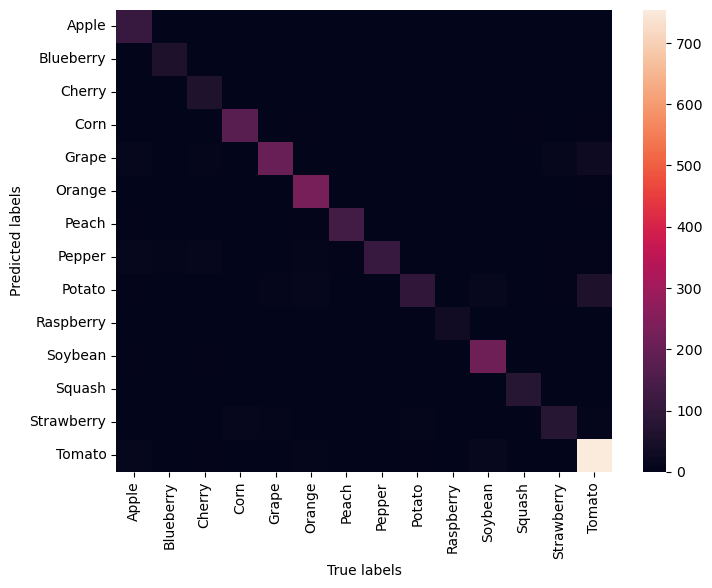

In [35]:
# Compute the confusion matrix
cm = confusion_matrix(valid_gen.classes, np.argmax(predictions, axis=-1))

#Compute the classification metrics
accuracy = accuracy_score(valid_gen.classes, np.argmax(predictions, axis=-1))
precision = precision_score(valid_gen.classes, np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(valid_gen.classes, np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(valid_gen.classes, np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm.T, xticklabels=list(valid_gen.class_indices), yticklabels=list(valid_gen.class_indices))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

tta_steps = 5
preds_tta = []
for i in range(tta_steps):
    aug_test_data_gen = ImageDataGenerator(rotation_range=30,
                                           height_shift_range=50,
                                           width_shift_range=50,
                                           zoom_range=0.3,
                                           horizontal_flip=True,
                                           vertical_flip=True, 
                                           fill_mode='reflect',
                                           rescale=1/255.)
    
    gen = ImageDataGenerator(fill_mode='constant', cval=0.)

    newX = gen.apply_transform(X, aug_test_data_gen)
    preds = model.predict(newX)
    #print('Before ', preds.shape)
    preds_tta.append(preds)
    #print(i,  len(preds_tta))
final_pred = np.mean(preds_tta, axis=0)

NameError: name 'X' is not defined

In [49]:
tta_steps = 5
preds_tta = []
for i in tqdm(range(tta_steps)):
    preds = model.predict(valid_gen)
    #     print('Before ', preds.shape)
    preds_tta.append(preds)
    #     print(i,  len(preds_tta))

100%|██████████| 5/5 [01:02<00:00, 12.56s/it]


In [25]:
final_pred = np.mean(preds_tta, axis=0)
predicted_class_indices = np.argmax(final_pred, axis=1)
final_pred.shape

(1779, 14)

In [27]:
# Predict the test set with the CNN
predictions = model.predict(valid_gen)
predictions.shape

(1779, 14)

In [53]:
# Compute the confusion matrix
cm = confusion_matrix(valid_gen.classes, np.argmax(final_pred, axis=-1))

#Compute the classification metrics
accuracy = accuracy_score(valid_gen.classes, np.argmax(final_pred, axis=-1))
precision = precision_score(valid_gen.classes, np.argmax(final_pred, axis=-1), average='macro')
recall = recall_score(valid_gen.classes, np.argmax(final_pred, axis=-1), average='macro')
f1 = f1_score(valid_gen.classes, np.argmax(final_pred, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm.T, xticklabels=list(valid_gen.class_indices), yticklabels=list(valid_gen.class_indices))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

NameError: name 'final_pred' is not defined

Accuracy: 0.9567
Precision: 0.9522
Recall: 0.9469
F1: 0.9489


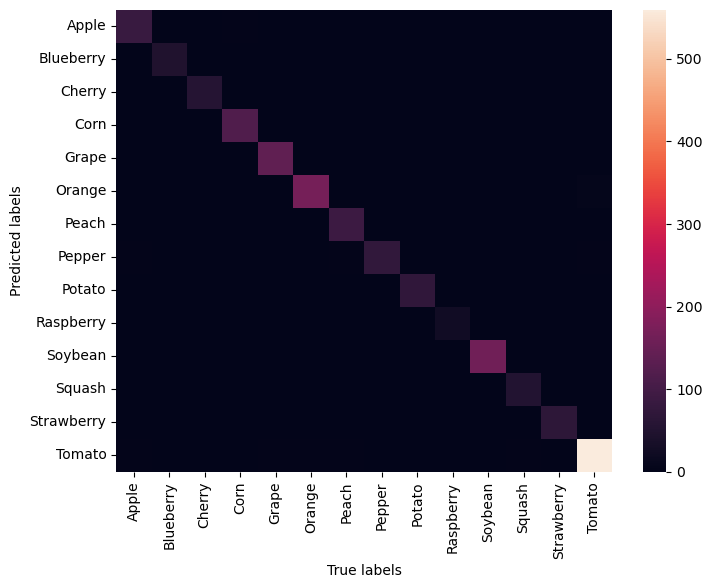

In [31]:
# Compute the confusion matrix
cm = confusion_matrix(valid_gen.classes, np.argmax(predictions, axis=-1))

#Compute the classification metrics
accuracy = accuracy_score(valid_gen.classes, np.argmax(predictions, axis=-1))
precision = precision_score(valid_gen.classes, np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(valid_gen.classes, np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(valid_gen.classes, np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm.T, xticklabels=list(valid_gen.class_indices), yticklabels=list(valid_gen.class_indices))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [15]:
%cd /Users/irfanmasudi/ANNDL/Challenge/datasets/train

/Users/irfanmasudi/ANNDL/Challenge/datasets/train


In [16]:
sample = []
for label in labels:
    count = 0
    dir = label
    for path in os.listdir(dir):
        if os.path.isfile(os.path.join(dir, path)):
            count += 1
    sample.append([label,count])
sample = pd.DataFrame(sample)
sample.columns=['class','count']
sample

class  count
0        Apple    889
1    Blueberry    420
2       Cherry    524
3         Corn   1085
4        Grape   1312
5       Orange   1573
6        Peach    879
7       Pepper    688
8       Potato    644
9    Raspberry    237
10     Soybean   1454
11      Squash    516
12  Strawberry    605
13      Tomato    870

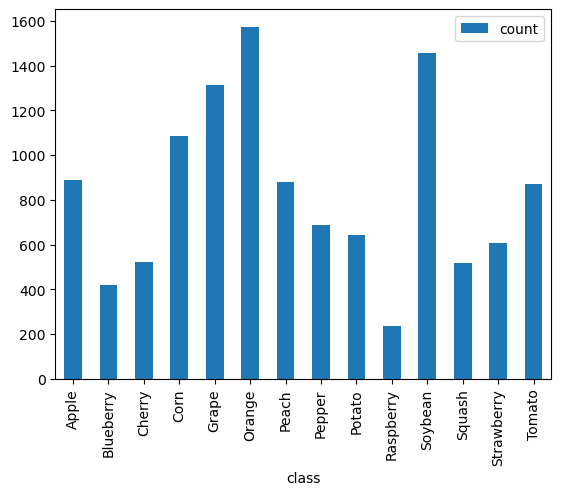

In [17]:
sample.plot(x='class', kind='bar')
plt.show()

In [32]:
y_pred = np.argmax(predictions, axis=1)
print('Confusion Matrix')
print(confusion_matrix(valid_gen.classes, y_pred))

Confusion Matrix
[[ 83   1   1   0   2   1   0   3   0   0   2   1   1   4]
 [  0  46   1   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0  56   0   0   0   0   1   0   0   1   0   0   1]
 [  3   0   0 116   0   0   0   0   0   0   0   1   0   1]
 [  0   0   2   0 138   0   0   0   1   0   0   1   1   3]
 [  0   1   2   0   0 168   0   0   0   0   1   0   0   3]
 [  1   1   0   0   0   0  89   4   0   0   0   0   0   3]
 [  1   0   0   0   0   1   0  73   0   0   1   0   0   1]
 [  0   0   0   0   0   0   0   0  70   0   1   0   0   1]
 [  0   0   0   0   0   0   0   0   0  26   0   0   1   0]
 [  1   0   0   0   0   0   0   0   0   0 160   0   0   1]
 [  1   0   0   2   0   0   0   0   0   0   0  52   0   3]
 [  0   0   0   0   0   0   0   0   0   0   0   0  66   2]
 [  0   1   0   0   0   5   1   3   1   0   0   0   0 559]]


In [ ]:
y_pred = np.argmax(final_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(valid_gen.classes, y_pred))

Confusion Matrix
[[ 90   0   2   0   1   0   0   3   0   0   0   1   0   2]
 [  0  47   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0  57   0   0   0   0   0   0   0   1   0   0   1]
 [  1   1   0 119   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0 141   0   0   0   1   0   0   1   2   1]
 [  0   1   0   0   0 173   0   1   0   0   0   0   0   0]
 [  0   0   0   0   0   0  94   1   0   0   0   0   0   3]
 [  0   0   0   0   0   0   0  73   0   0   2   0   0   2]
 [  0   0   0   0   0   0   0   0  68   0   3   0   0   1]
 [  0   0   0   0   0   0   0   0   0  27   0   0   0   0]
 [  1   0   0   0   0   0   0   0   0   0 160   0   0   1]
 [  0   0   0   2   1   0   0   0   0   0   0  52   0   3]
 [  0   0   0   0   1   0   0   0   0   0   0   0  66   1]
 [  0   0   0   0   0   0   0   0   1   0   0   0   0 569]]
